## 对开源项目neural-fingerprint-theano中生成的分子图数据进行整理，
了解`atom_features` `bond_features`矩阵中所代表的意思

https://github.com/debbiemarkslab/neural-fingerprint-theano


In [4]:
import getpass
from neural_fingerprint_theano.code.rdkit_preprocessing import neuralFingerprintUtils
from neural_fingerprint_theano.code.rdkit_preprocessing import genConvMolFeatures
from neural_fingerprint_theano.code.prediction import seqHelper
from rdkit import Chem
import numpy as np

In [4]:
def prepare_data():
    data_dir = '/home/'+getpass.getuser()+'/git_test/neural_fingerprint_theano/data'
    expr_filename = data_dir+'/csv_files/logSolubilityTest.csv'
    fingerprint_filename = data_dir + '/temp/logSolubilityInput_withRDKITidx.pkl'

    smiles_to_measurement,smiles_to_atom_info,smiles_to_bond_info,\
        smiles_to_atom_neighbors,smiles_to_bond_neighbors,smiles_to_atom_mask,\
        smiles_to_rdkit_list,max_atom_len,max_bond_len,num_atom_features,num_bond_features\
        = seqHelper.read_in_data(expr_filename, fingerprint_filename)

    smiles_list = smiles_to_measurement.keys()
    sm = smiles_list[0]
    atom_info = smiles_to_atom_info[sm]
    bond_info = smiles_to_bond_info[sm]
    atom_neighbors = smiles_to_atom_neighbors[sm]
    bond_neighbors = smiles_to_bond_neighbors[sm]
    atom_mask = smiles_to_atom_mask[sm]
    rdkit_list = smiles_to_rdkit_list[sm]

    print type(atom_info), atom_info.shape
    print type(bond_info), bond_info.shape
    print type(atom_neighbors), atom_neighbors.shape
    print type(bond_neighbors), bond_neighbors.shape

In [5]:
prepare_data()

<type 'numpy.ndarray'> (56, 68)
<type 'numpy.ndarray'> (63, 6)
<type 'numpy.ndarray'> (56, 6)
<type 'numpy.ndarray'> (56, 6)


In [56]:
def mol_features():
    """
    atom_features:
        ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na',
         'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb',
         'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H',    # H?
         'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr',
         'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']  ## 44
         [0, 1, 2, 3, 4, 5] # atom degree
         [0, 1, 2, 3, 4]    # total num Hs
         [0, 1, 2, 3, 4, 5] # implicit valence
         [isAromatic]
         [-2,-1,0,1,2,'Unknown'] # formal charge
    
    bond_features:
        ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'IsConjugated', 'IsInRing']

    """
    sm = 'c1ccccc1O'
    mol = Chem.MolFromSmiles(sm)
    atom_feat_dic = {}
    for atom in mol.GetAtoms():
        feat = neuralFingerprintUtils.atom_features(atom)
        symb = atom.GetSymbol()
        id = atom.GetIdx()
        atom_feat_dic[symb+str(id)] = feat
    
    bond_feat_dic = {}
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        bond_name = atom1.GetSymbol()+str(atom1.GetIdx())+'_'+atom2.GetSymbol()+str(atom2.GetIdx())
        feat = neuralFingerprintUtils.bond_features(bond)
        bond_feat_dic[bond_name] = feat
    
    return atom_feat_dic, bond_feat_dic

atom_feat_dic, bond_feat_dic = mol_features()
for k, v in bond_feat_dic.items():
    print k, v

C4_C5 [False False False  True  True  True]
C1_C2 [False False False  True  True  True]
C3_C4 [False False False  True  True  True]
C0_C1 [False False False  True  True  True]
C2_C3 [False False False  True  True  True]
C5_C0 [False False False  True  True  True]
C5_O6 [ True False False False  True False]


In [44]:
for k, v in feat_dic.items():
    print k, 'atom_degree', v[44:50], 'num Hs', v[50:55]
    print '  implicit valence', v[55:61], 'isAromatic', v[61:62]
    print '  formalcharge', v[62:68]
    print

O6 atom_degree [False  True False False False False] num Hs [False  True False False False]
  implicit valence [False  True False False False False] isAromatic [False]
  formalcharge [False False  True False False False]

C3 atom_degree [False False  True False False False] num Hs [False  True False False False]
  implicit valence [False  True False False False False] isAromatic [ True]
  formalcharge [False False  True False False False]

C2 atom_degree [False False  True False False False] num Hs [False  True False False False]
  implicit valence [False  True False False False False] isAromatic [ True]
  formalcharge [False False  True False False False]

C1 atom_degree [False False  True False False False] num Hs [False  True False False False]
  implicit valence [False  True False False False False] isAromatic [ True]
  formalcharge [False False  True False False False]

C0 atom_degree [False False  True False False False] num Hs [False  True False False False]
  implicit valence [

### `arrayrep`中`atom_features`矩阵中行的顺序是按照`atom degree`来排列的

### `bond_features`矩阵中行的顺序是按照最初生成`bond`的顺序排列的

In [54]:
sm = 'c1ccccc1O'
molgraph = genConvMolFeatures.graph_from_smiles(sm)
molgraph.sort_nodes_by_degree('atom')
arrayrep = genConvMolFeatures.array_rep_from_smiles(molgraph)
print len(molgraph.nodes['atom'])
print len(molgraph.nodes['bond'])
print arrayrep.keys()
print arrayrep['bond_features']
print 'atom features, sorted by atom degree'
print arrayrep['atom_features'][:, 44:50]

7
7
[('bond_neighbors', 1), 'bond_features', 'atom_list', ('bond_neighbors', 2), ('atom_neighbors', 5), ('bond_neighbors', 3), 'atom_features', ('atom_neighbors', 4), ('bond_neighbors', 5), 'rdkit_ix', ('atom_neighbors', 0), ('atom_neighbors', 1), ('atom_neighbors', 2), ('bond_neighbors', 4), ('bond_neighbors', 0), ('atom_neighbors', 3)]
[[False False False  True  True  True]
 [False False False  True  True  True]
 [False False False  True  True  True]
 [False False False  True  True  True]
 [False False False  True  True  True]
 [ True False False False  True False]
 [False False False  True  True  True]]
atom features, sorted by atom degree
[[False  True False False False False]
 [False False  True False False False]
 [False False  True False False False]
 [False False  True False False False]
 [False False  True False False False]
 [False False  True False False False]
 [False False False  True False False]]


[6 0 1 2 3 4 5 7]
{'c1ccccc1O': 1.0}
[[5 7 7 7 7 7]
 [1 5 7 7 7 7]
 [0 2 7 7 7 7]
 [1 3 7 7 7 7]
 [2 4 7 7 7 7]
 [3 5 7 7 7 7]
 [4 6 0 7 7 7]
 [7 7 7 7 7 7]]
[[None 7 7 7 7 7]
 [None None 7 7 7 7]
 [None None 7 7 7 7]
 [None None 7 7 7 7]
 [None None 7 7 7 7]
 [None None 7 7 7 7]
 [None None None 7 7 7]
 [7 7 7 7 7 7]]
[ 1.  1.  1.  1.  1.  1.  1.  0.]


Using TensorFlow backend.


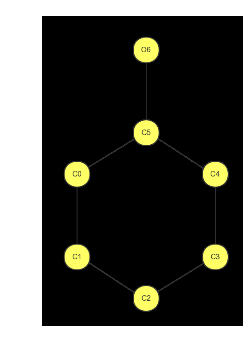

In [5]:
def test_c1ccccc1O():
    sm = 'c1ccccc1O'
    data_dir = '/home/'+getpass.getuser()+'/git_test/neural_fingerprint_theano/data'
    expr_filename = data_dir+'/huizhu/logP_c1ccccc1O.dat'
    fingerprint_filename = data_dir + '/huizhu/c1ccccc1O.pkl'

    smiles_to_measurement,smiles_to_atom_info,smiles_to_bond_info,\
        smiles_to_atom_neighbors,smiles_to_bond_neighbors,smiles_to_atom_mask,\
        smiles_to_rdkit_list,max_atom_len,max_bond_len,num_atom_features,num_bond_features\
        = seqHelper.read_in_data(expr_filename, fingerprint_filename)
    
    molgraph = genConvMolFeatures.graph_from_smiles(sm)
    molgraph.sort_nodes_by_degree('atom')
    
    atom_neighbors = smiles_to_atom_neighbors[sm].astype(int) # atom index in molgraph.nodes['atom']
    atom_rdkit_idx = [a.rdkit_ix for a in molgraph.nodes['atom']]
    atom_rdkit_idx.append(len(atom_rdkit_idx))
    atom_rdkit_idx = np.asarray(atom_rdkit_idx) 
    
    bond_neighbors = smiles_to_bond_neighbors[sm].astype(int)
    bond_rdkit_idx = [a.rdkit_ix for a in molgraph.nodes['bond']]
    bond_rdkit_idx.append(len(bond_rdkit_idx))
    bond_rdkit_idx = np.asarray(bond_rdkit_idx)
    
    print atom_rdkit_idx
    print smiles_to_measurement
    print atom_rdkit_idx[atom_neighbors]  ## true atom rdkit index
    print bond_rdkit_idx[bond_neighbors]
    
    mask = smiles_to_atom_mask[sm]
    print mask
    
    from Teemo.algorithm.preprocessing import image
    import matplotlib.pyplot as plt
    img = image.load_img(data_dir + '/huizhu/c1ccccc1O.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    

test_c1ccccc1O()